In [1]:
from sklearn import metrics,datasets,cluster,preprocessing
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import *
import seaborn as sns
from sklearn.svm import SVC

#設定能顯示全部結果
np.set_printoptions(threshold=np.inf)

#讀取檔案
excel_file = "data500_groups.xlsx"
file = pd.read_excel(excel_file,sheet_name = 3)

#填補缺值
file = file.fillna(axis = 0, method = 'ffill')

#查看資料
file.head()

,單據日期,客戶簡稱,貨品編號,貨品名稱,單位,數量,單價,小計,合計金額,總計金額,貨品分組
0,2018/01/02,403504.0,4.712121e+12,池農池上米1KG,個,1.0,115.0,115.0,115.0,115.0,471.0
1,2018/01/02,40128.0,4.710466e+12,妙潔耐熱袋 半斤,個,2.0,39.0,78.0,78.0,78.0,471.0
2,2018/01/02,403504.0,4.718837e+12,尚豪衣架,個,1.0,48.0,48.0,48.0,48.0,471.0
3,2018/01/02,403504.0,4.904531e+12,東芝碳鋅電池4號4入,個,1.0,27.0,27.0,27.0,27.0,490.0
4,2018/01/03,469760.0,4.710632e+12,悅氏礦泉水(小),個,1.0,7.0,7.0,7.0,7.0,471.0


In [2]:
#切片擷取 file 裡面的"商品名稱","單價"與"數量"
file_temp = file.iloc[:,[3,5,6]]

#GroupBy "貨品名稱"
product = file_temp.groupby(by = "貨品名稱")

#創建只包含"貨品名稱","平均單價"與"總數量"的 dictionary
product_dic = {
    "平均單價":product["單價"].mean(),
    "總數量": product["數量"].sum()
}

#將 dictionary 轉為 DataFrame
product_df = pd.DataFrame(product_dic)
product_df.head(20)

,平均單價,總數量
貨品名稱,,
(盛)甘草瓜子,60.0,15.0
(盛)醬油瓜子,60.0,2.0
0.33罐裝啤酒,27.0,12.0
0.33罐裝爽啤,25.0,1.0
0.5罐裝啤酒,36.0,16.0
0.6米酒頭,140.0,3.0
0.75特級高梁酒〈二鍋頭〉,612.0,2.0
1/2 林鳳營鮮乳,152.0,1.0
10元百樂PE-40橡皮擦,8.0,2.0


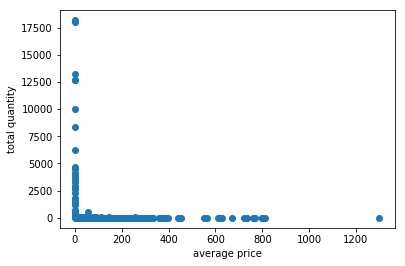

In [3]:
#畫圖查看"平均單價"與"總數量"的關係
plt.scatter(x=product_df["平均單價"],y=product_df["總數量"])
plt.xlabel("average price")
plt.ylabel("total quantity")
plt.show()

In [4]:
#查看極端值
product_df[product_df["平均單價"]>1000]
#發現是蔬果類資料，且只有一筆，因此我們決定移除這筆資料

,平均單價,總數量
貨品名稱,,
玉山果園新興梨,1300.0,3.0


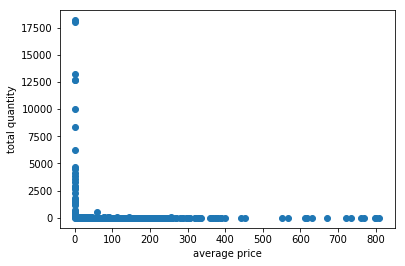

In [5]:
#移除極端值後的資料與分佈
product_df = product_df[product_df["平均單價"]<1000]
plt.scatter(x=product_df["平均單價"],y=product_df["總數量"])
plt.xlabel("average price")
plt.ylabel("total quantity")
plt.show()
#我們發現大部分的商品的平均單價都落在400元以內

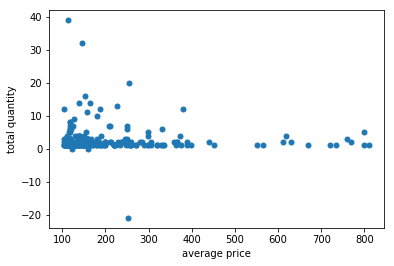

In [6]:
#觀察平均單價100元以上的商品
product_df2 = product_df[(product_df["平均單價"] > 100)]
plt.scatter(x = product_df2["平均單價"],y = product_df2["總數量"],s = 25)
plt.xlabel("average price")
plt.ylabel("total quantity")
plt.show()
#我們發現100元以上的商品銷售數量都不超過40個，然而前一個圖表中的銷售數量竟達到17500，可見100元以內的商品的"銷售數量"遠大於100元以上的商品!


In [7]:
#查看平均單價為1的商品
product_df[product_df["平均單價"] == 1]
#發現水果跟漁獲類是因為價格波動太大，定價比較不好制定，所以可能會用數量去計算總金額，也因此數量會很多，但價格卻是1元
#或者是有些資料反了

,平均單價,總數量
貨品名稱,,
三崧進口有機蔬果,1.0,254.0
二手書籍[#]2085,1.0,6250.0
亞尼克生乳捲,1.0,1390.0
優品通路商品,1.0,264.0
冠諭鮮活農市農特產品,1.0,1850.0
凱京鞋業,1.0,13260.0
卡馬龍無毒海產[#]2178,1.0,1596.0
土耳其Dalan系列商品[#]2221,1.0,160.0
大裕農場產品,1.0,300.0


In [8]:
#查看平均單價小於10元的商品
product_df[(product_df["平均單價"] < 10) & (product_df["平均單價"] != 1)]
#發現有些10元商品會有折扣，因此平均價格會比原本的低
#平均價格相對而言會比外面超商便宜，但銷售的總數量卻不多
#通常學生購買的商品的價格都會較低，然而這裡我們發現這些便宜的商品銷量卻不多，因此我們覺得學生族群不常來消費

,平均單價,總數量
貨品名稱,,
10元百樂PE-40橡皮擦,8.0,2.0
10元鳳紋香水紅包禮袋,8.0,1.0
330鮮地蘋果C300,8.0,3.0
330鮮地蜜桃C300,8.0,2.0
6元金小小美工刀,5.0,4.0
OB 100原子筆.5紅,6.0,2.0
OK 衣夾 B,9.0,1.0
PKL300大麥紅茶,8.0,1.0
PLUS 10號訂書針,6.0,1.0


In [9]:
#從資料我們發現
#很多商品都不是學生會買的，比較像是教師或者是附近住戶購買的。

#為什麼合作社不討學生族群喜愛？我們認為可能是因為要註冊會員
#大部分人來合作社都比較多是買食物或生鮮食品，如果拿來跟五八一比較，五八一像是便利購可以購買生活用品，我們認為地點也可能是影響因素之一

In [10]:
# KMeans 演算法(對 平均單價&總數量scatter分兩群)
kmeans_fit = cluster.KMeans(n_clusters = 2).fit_predict(product_df)

print("分群結果：")
print(kmeans_fit)
print("---")

print("真實貨品名稱：")
print(product_df)

分群結果：
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

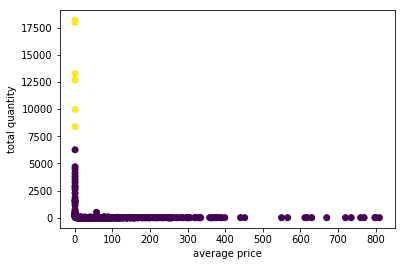

In [11]:
#分群兩群結果scatter
plt.scatter(x = product_df["平均單價"],y = product_df["總數量"],c = kmeans_fit)
plt.xlabel("average price")
plt.ylabel("total quantity")
plt.show()

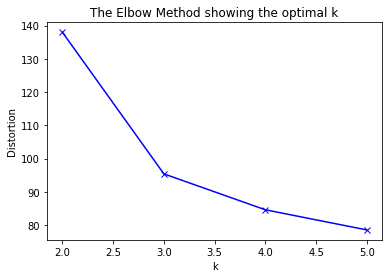

In [12]:
#Elbow method
distortions = []
K = range(2,6)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k).fit(product_df)
    kmeanModel.fit(product_df)
    distortions.append(sum(np.min(cdist(product_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / product_df.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
#看出分三群最佳

In [13]:
# Avg. Silhouette
slist = []
for i in range(2,15):
    kmeans_fit_temp = cluster.KMeans(n_clusters = i).fit_predict(product_df)
    silhouette_avg = metrics.silhouette_score(product_df,kmeans_fit_temp)
    slist.append(silhouette_avg)
num = [2,3,4,5,6,7,8,9,10,11,12,13,14]
Silhouette_df = pd.DataFrame({
    "number":num,
    "rate":slist
})
print(Silhouette_df)

    number      rate
0        2  0.984174
1        3  0.967334
2        4  0.964984
3        5  0.963409
4        6  0.948009
5        7  0.783429
6        8  0.784022
7        9  0.788123
8       10  0.673097
9       11  0.644279
10      12  0.675367
11      13  0.636310
12      14  0.636205


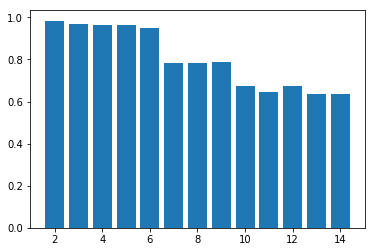

In [14]:
# Avg. Silhouette bar plot
plt.bar(Silhouette_df["number"],Silhouette_df["rate"])
plt.show()

In [15]:
# KMeans 演算法(參考Elbow Method 我們決定將"單價&數量"分成三群)
kmeans_fit2 = cluster.KMeans(n_clusters = 3).fit_predict(product_df)

# 印出分群結果
print("分群結果：")
print(kmeans_fit2)
print("---")

分群結果：
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

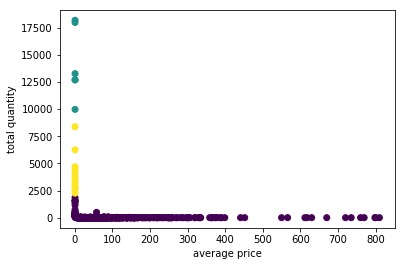

In [16]:
#分群三群結果scatter
plt.scatter(x = product_df["平均單價"],y = product_df["總數量"],c = kmeans_fit2)
plt.xlabel("average price")
plt.ylabel("total quantity")
plt.show()

In [17]:
#因為黃色群跟綠色群的平均單價差不多，因此造成變動的主因是總數量
#然而紫色群是真正受到總數量與平均單價共同影響很大的

In [18]:
#我們認為可以記錄客人的年齡、性別與購買時間，例如觀察下午五點過後的購買情形，便可以大致判斷學生客群與其他客群的消費比較